# LAB5

In [10]:
import numpy as np 
from matplotlib import pyplot as plt 
import math
import os

In [67]:
class PGMImage:
    def __init__(self, file_path=None):
        self.magic_number = None
        self.width = 0
        self.height = 0
        self.maxval = 0
        self.pixels = []
        self.pixels_2d = [[]]

        if file_path:
            self.mypgmread(file_path)
            self.pixels_2d = np.array(self.pixels, dtype=np.uint8).reshape((self.height, self.width))


    def mypgmread(self, file_path):
        with open(file_path, 'rb') as file:
            self.magic_number = file.readline().strip().decode('ascii')

            line = file.readline().strip()
            while line.startswith(b'#'): 
                line = file.readline().strip()

            self.width, self.height = map(int, line.split())
            self.maxval = int(file.readline().strip())
            data = file.read()
            self.pixels = list(data)

    def modify_pixels(self, row_start, row_end, new_value):
        pixels_2d = np.array(self.pixels, dtype=np.uint8).reshape((self.height, self.width))
        pixels_2d[row_start:row_end, :] = new_value
        self.pixels = pixels_2d.flatten().tolist()

    def mypgmwrite(self, filename):
        pixel_array = np.array(self.pixels, dtype=np.uint8).reshape((self.height, self.width))

        with open(filename, 'wb') as file:
            file.write(f"{self.magic_number}\n".encode())
            file.write(f"{self.width} {self.height}\n".encode())
            file.write(f"{self.maxval}\n".encode())
            pixel_array.tofile(file)



####################################################################################################################################################
############################## LAB-03 FONKSİYONLARI ################################################################################################
####################################################################################################################################################

    # 2D Fourier Dönüşümünü hesaplamak için fonksiyon
    def my2Dfft(self, image= None, point_m = None, point_n = None):
        if image is None:
            image = self.pixels_2d  # Varsayılan olarak sınıfın görüntüsünü kullanır
        
        # Giriş görüntüsünün boyutlarını al
        height, width = image.shape
        if point_m == None:
            point_m = height
        if point_n == None:
            point_n = width
        # Fourier Dönüşümü sonucunu tutacak karmaşık (complex) dizi oluştur
        fourier_array = np.zeros(shape = (point_m, point_n), dtype=complex)
        # Satır bazında 1D FFT uygulanır
        for i in range(height):
            fourier_array[i] = np.fft.fft(image[i], n = point_n)
        
        # Sütun bazında 1D FFT uygulanır
        for k in range(point_n):
            fourier_array[:, k] = np.fft.fft(fourier_array[:, k], n = point_m)
        
        return fourier_array

# Ortalanmış Fourier dönüşüm maskesi uygulayan fonksiyon
    def centered_fourier(self):
        centered_mask = np.zeros((self.height, self.width), dtype=complex)
        for x in range(0 , self.height):
            for y in range(0 , self.width):
                centered_mask[x][y] = (-1)**(x + y)

        return centered_mask * self.pixels_2d


# 2D Ters Fourier Dönüşümünü hesaplamak için fonksiyon
    def my2Difft(self, image = None, point_m = None, point_n = None):
        try:
            if image:
                pass
            else:
                image = self.pixels_2d
        except:
            pass    
        
        conj_input = np.conj(image)     # Giriş görüntüsünün konjugesini al
        conj_output = self.my2Dfft(conj_input, point_m, point_n) # konjugesi alınmış görüntünün fourier transformunu al
        inverse_conj_output = conj_output / (self.height * self.width) # Çıktıyı satır*sütun değerine böl
        inverse_image = np.conj(inverse_conj_output) # çıkış değerinin de konjugesi alınır ve original image elde edilir.

        return inverse_image


    def myImageCorrelation(self, kernel, image = None): # kernel dışarıdan verilir
        try:
            if image:
                pass
            else:
                image = self.pixels_2d
        except:
            pass   
        k_height, k_width = kernel.shape # kernelin yükseklik ve genişliği .shape ile elde edilir
        g = np.zeros((self.height, self.width), dtype=np.float32) # çıkış değerini tutmak için imagein boyutlarında 0'lardan oluşan liste oluşturulur            pixels_2d = np.array(self.pixels, dtype=np.uint8).reshape((self.height, self.width)) # orjinal imagein pixelleri boyutlandırlır
        
        for x in range(0 , self.height): # orjinal görüntünün her pixelinde işlem yapmak için for döngüsü kurulur
            for y in range(0, self.width):
                for s in range(-k_height//2 + 1, k_height//2 +1): # kernelin her bir değerinde işlem yapmak için for döngüleri kurulur
                    for t in range(-k_width//2 + 1, k_width//2 + 1):
                        if 0 <= x + s < self.height and 0 <= y + t < self.width \
                            and 0 <= s + k_height//2 < k_height and 0 <= t + k_width//2 < k_width:
                            g[x][y] += kernel[s + k_height // 2][t + k_width // 2] * self.pixels_2d[x + s][y + t]   
        return g # çıkış değeri iki boyutlu olarak döndürülür
    
    def myHistogramEqualization(self): # histogram eşitleme fonksiyonu
        pixel = np.zeros((self.height, self.width), dtype=np.float32) # boş pixel değerleri  oluşturulur.

        hist, _ = np.histogram(self.pixels, 256, [0, 256]) # pixels değerlerine göre historam oluşturulur.
        
        cdf = np.zeros(256, dtype=np.float32) # kümülatif dağılım için boş dizi oluşturulur.
        cdf[0] = hist[0] # ilk histogram değeri cdf e atanır

        for i in range(1, 256):
            cdf[i] = hist[i] + cdf[i - 1] # önceki cdf değerine histogram değeri eklenir

        cdf_normalized = cdf / cdf[-1]  # cdf normalize edilir bütün değerler 0-1 aralığına sıkıştırılır

        for i in range(256): # her bir yoğunluk seviyesine yeni bir piksel değeri atanır
            pixel_value = int(cdf_normalized[i] * 255)
            cdf[i] = pixel_value

        for i in range(len(self.pixels)): # Görüntüdeki her piksel değeri, yeni hesaplanan cdf değerine göre değiştirilir.
            self.pixels[i] = cdf[self.pixels[i]]

        return self.pixels, cdf_normalized  

    def basicGlobalThresholding(self, initial_threshold, tolerance=3):
        T_old = initial_threshold
        while True:
            # Segment the image using the current threshold
            group1 = self.pixels_2d[self.pixels_2d > T_old]  # Pixels with intensity > T_old
            group2 = self.pixels_2d[self.pixels_2d <= T_old]  # Pixels with intensity <= T_old

            # Avoid empty groups
            mean1 = np.mean(group1) if group1.size > 0 else 0
            mean2 = np.mean(group2) if group2.size > 0 else 0

            # Compute the new threshold
            T_new = (mean1 + mean2) / 2

            # Check for convergence
            if abs(T_new - T_old) < tolerance:

                break

            # Update the threshold
            T_old = T_new

        # Segment the image using the final threshold
        segmented_image = np.where(self.pixels_2d > T_new, 255, 0).astype(np.uint8)

        return T_new, segmented_image


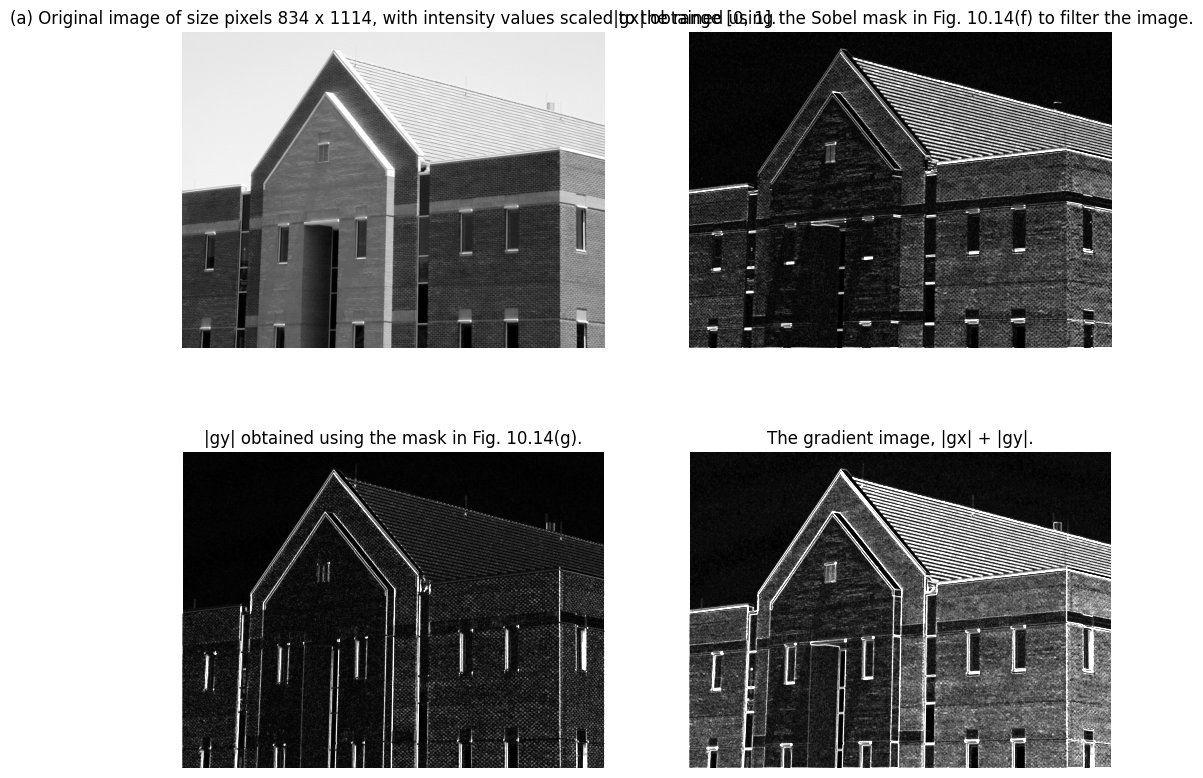

In [39]:
image = PGMImage('Fig1016(a)(building_original).pgm')

sobel_x = np.array( [[-1,-2,-1],
                     [0, 0, 0],
                     [1, 2, 1]])

sobel_y = np.array( [[-1, 0, 1],
                     [-2, 0, 2],
                     [-1, 0, 1]])

gx = image.myImageCorrelation(sobel_x)
gy = image.myImageCorrelation(sobel_y)

g = np.abs(gx) + np.abs(gy)

plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.title("(a) Original image of size pixels 834 x 1114, with intensity values scaled to the range [0, 1].")
plt.axis('off')
plt.imshow(image.pixels_2d, cmap="gray", vmin=0, vmax=255)

plt.subplot(2, 2, 2)
plt.title(" |gx| obtained using the Sobel mask in Fig. 10.14(f) to filter the image.")
plt.axis('off')
plt.imshow(np.abs(gx), cmap="gray", vmin=0, vmax=255)

plt.subplot(2, 2, 3)
plt.title("|gy| obtained using the mask in Fig. 10.14(g).")
plt.axis('off')
plt.imshow(np.abs(gy), cmap="gray", vmin=0, vmax=255)

plt.subplot(2, 2, 4)
plt.title("The gradient image, |gx| + |gy|.")
plt.axis('off')
plt.imshow(g, cmap="gray", vmin=0, vmax=255)


In [45]:
image = PGMImage('Fig1016(a)(building_original).pgm')
average_filter = np.ones((5, 5)) / 25

sobel_x = np.array( [[-1,-2,-1],
                     [0, 0, 0],
                     [1, 2, 1]])

sobel_y = np.array( [[-1, 0, 1],
                     [-2, 0, 2],
                     [-1, 0, 1]])

smoothed_image = image.myImageCorrelation(average_filter)
gx = image.myImageCorrelation(smoothed_image, sobel_x)
gy = image.myImageCorrelation(smoothed_image, sobel_y)

g = np.abs(gx) + np.abs(gy)

plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.title("(a) Original image of size pixels 834 x 1114, with intensity values scaled to the range [0, 1].")
plt.axis('off')
plt.imshow(smoothed_image, cmap="gray", vmin=0, vmax=255)

plt.subplot(2, 2, 2)
plt.title(" |gx| obtained using the Sobel mask in Fig. 10.14(f) to filter the image.")
plt.axis('off')
plt.imshow(np.abs(gx), cmap="gray", vmin=0, vmax=255)

plt.subplot(2, 2, 3)
plt.title("|gy| obtained using the mask in Fig. 10.14(g).")
plt.axis('off')
plt.imshow(np.abs(gy), cmap="gray", vmin=0, vmax=255)

plt.subplot(2, 2, 4)
plt.title("The gradient image, |gx| + |gy|.")
plt.axis('off')
plt.imshow(g, cmap="gray", vmin=0, vmax=255)


KeyboardInterrupt: 

139.96595612203788


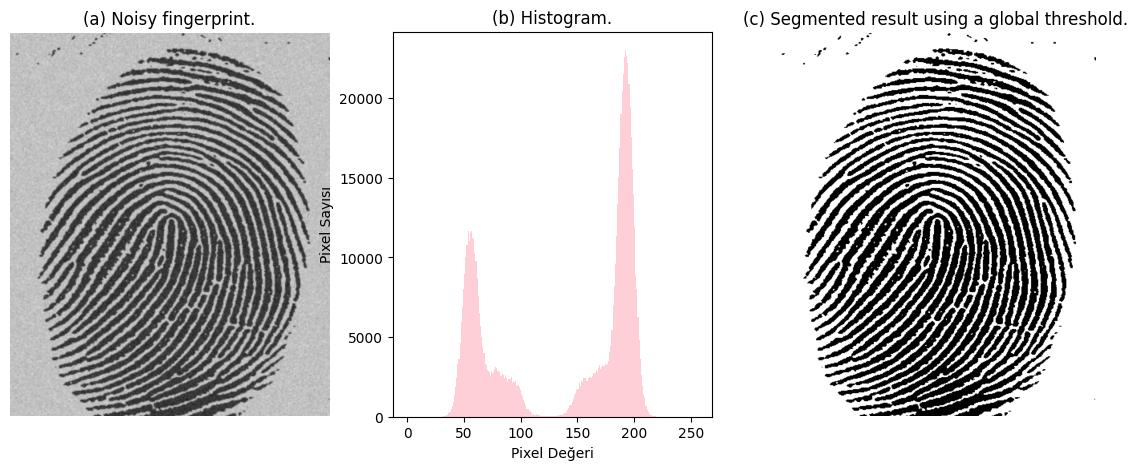

In [69]:
image = PGMImage('Fig1038(a)(noisy_fingerprint).pgm')

initial_threshold = np.mean(image.pixels_2d)
print(initial_threshold)
final_threshold, segmented_image = image.basicGlobalThresholding(125)

plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.title("(a) Noisy fingerprint.")
plt.axis('off')
plt.imshow(image.pixels_2d, cmap="gray", vmin=0, vmax=255)

plt.subplot(1, 3, 2)
plt.title("(b) Histogram.")
plt.hist(image.pixels_2d.ravel(), bins=256, range=[0, 256], color='pink', alpha=0.75)
plt.xlabel('Pixel Değeri')
plt.ylabel('Pixel Sayısı')

plt.subplot(1, 3, 3)
plt.title("(c) Segmented result using a global threshold.")
plt.axis('off')
plt.imshow(segmented_image, cmap="gray", vmin=0, vmax=255)

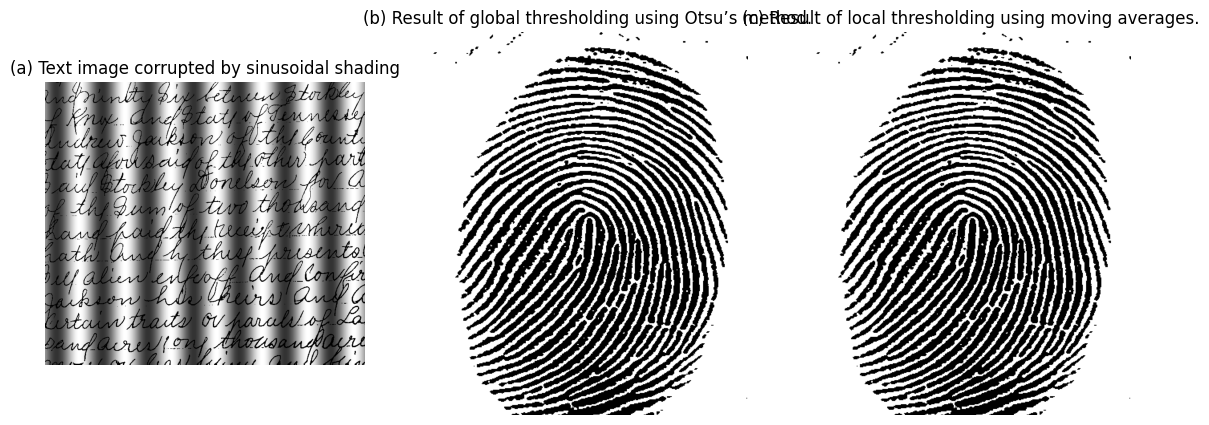

In [70]:
image = PGMImage('Fig1050(a)(sine_shaded_text_image).pgm')

plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.title("(a) Text image corrupted by sinusoidal shading")
plt.axis('off')
plt.imshow(image.pixels_2d, cmap="gray", vmin=0, vmax=255)

plt.subplot(1, 3, 2)
plt.title("(b) Result of global thresholding using Otsu’s method.")
plt.axis('off')
plt.imshow(segmented_image, cmap="gray", vmin=0, vmax=255)

plt.subplot(1, 3, 3)
plt.title("(c) Result of local thresholding using moving averages.")
plt.axis('off')
plt.imshow(segmented_image, cmap="gray", vmin=0, vmax=255)